# **Import Packages**

In [ ]:
import numpy as np
from PIL import Image
import random

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

import torchvision
from torchvision import datasets
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms
import torchvision.models as models

# This is for the progress bar
from tqdm.auto import tqdm
# This is for ploting
import matplotlib.pyplot as plt

In [ ]:
# Install a package to download data from Kaggle
!pip install -q opendatasets

In [ ]:
import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/sunilthite/cat-or-dog-image-classification/')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: usmanade23
Your Kaggle Key: ··········


100%|██████████| 599M/599M [00:05<00:00, 108MB/s]


## **Dataset and Dataloader**

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=224),  # Random crop and resize
    transforms.RandomHorizontalFlip(),       # Random horizontal flip
    transforms.RandomRotation(degrees=10),    # Random rotation
#    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

## **Split Data into Train, Validation and Test**

In [ ]:
train_dataset = datasets.ImageFolder("/content/cat-or-dog-image-classification/Train", transform=train_transform)
test_dataset = datasets.ImageFolder("/content/cat-or-dog-image-classification/Test", transform=test_transform)

# 90%  of the dataset is used for training while 10% is used for evaluation
train_ratio = 0.9
val_ratio = 1 - train_ratio

# Sizes of train and evaluation datasets based on the ratios
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the train dataset into train and evaluation subsets
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

print(f'Original train set has {len(train_dataset)} samples')
print(f'Train set has {len(train_subset)} samples')
print(f'Validation set has {len(val_subset)} samples')
print(f'Test set has {len(test_dataset)} samples')

Original train set has 23650 samples
Train set has 21285 samples
Validation set has 2365 samples
Test set has 3863 samples


In [ ]:
batch_size = 32

# Construct data loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## **Exploratory Data Analysis**

In [ ]:
# Count the occurrences of each class label
cat_count = sum(1 for _, label in train_subset if label == 0)  # Assuming 0 is the label for cats
dog_count = sum(1 for _, label in train_subset if label == 1)  # Assuming 1 is the label for dogs

print("Value counts in training data:")
print("Cat count:", cat_count)
print("Dog count:", dog_count)

Value counts in training data:
Cat count: 10634
Dog count: 10651


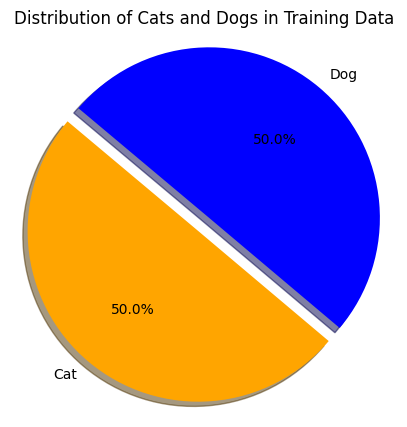

In [ ]:
# Data to plot
labels = ['Cat', 'Dog']
sizes = [cat_count, dog_count]
colors = ['orange', 'blue']
explode = (0.1, 0)

# Plot
plt.figure(figsize=(5, 5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.title('Distribution of Cats and Dogs in Training Data')
plt.axis('equal')
plt.show()

**Display some cat images**

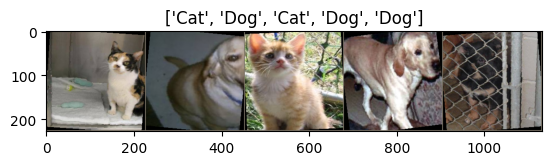

In [ ]:
# Define the function to display images
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)  # clip values to [0, 1] range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
train_loader_for_vis = DataLoader(train_subset, batch_size=5, shuffle=True, num_workers=0)
inputs, classes = next(iter(train_loader_for_vis))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Define class names (assuming binary classification)
class_names = ['Cat', 'Dog']

# Display the batch of images with their labels
imshow(out, title=[class_names[x] for x in classes])

plt.show()  # Show the plot

## **MODELING (VGG 16)**

In [ ]:
class MyVGG16(nn.Module):
    def __init__(self):
        super(MyVGG16, self).__init__()

        # Load the pre-trained VGG16 model
        vgg16 = models.vgg16(pretrained=True)

        # Extract only the convolutional layers from the pre-trained VGG16 model
        self.features = vgg16.features

        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 2)  # Output layer with 2 classes
        )

    def forward(self, x):

        # Extract features using VGG16's convolutional layers
        x = self.features(x)

        # Flatten the feature map
        x = x.view(x.size(0), -1)

        # Pass through fully connected layers
        x = self.fc_layers(x)

        return x

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = MyVGG16()
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 108MB/s]


In [ ]:
from torchsummary import summary

In [ ]:
# showing summary of MyVGG16 model
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

**Define Loss and Optimizer**

In [ ]:
# Define Loss
criterion = nn.CrossEntropyLoss()

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

**Train and Validation**

In [ ]:
# The number of training epochs.
n_epochs = 10

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data.
        logits = model(imgs)

        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------

    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 001/010] Train: loss=0.20240, acc=0.91305 | Valid: loss=0.16144, acc=0.93517


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 002/010] Train: loss=0.15574, acc=0.93389 | Valid: loss=0.12306, acc=0.94417


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 003/010] Train: loss=0.14124, acc=0.94041 | Valid: loss=0.15378, acc=0.93103


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 004/010] Train: loss=0.13134, acc=0.94463 | Valid: loss=0.14022, acc=0.93285


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 005/010] Train: loss=0.12919, acc=0.94449 | Valid: loss=0.10606, acc=0.95566


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 006/010] Train: loss=0.12456, acc=0.94733 | Valid: loss=0.13014, acc=0.93783


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 007/010] Train: loss=0.11899, acc=0.94802 | Valid: loss=0.10379, acc=0.95308


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 008/010] Train: loss=0.11702, acc=0.94912 | Valid: loss=0.18834, acc=0.92554


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 009/010] Train: loss=0.11888, acc=0.94843 | Valid: loss=0.12794, acc=0.94666


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 010/010] Train: loss=0.11599, acc=0.95170 | Valid: loss=0.12612, acc=0.95139


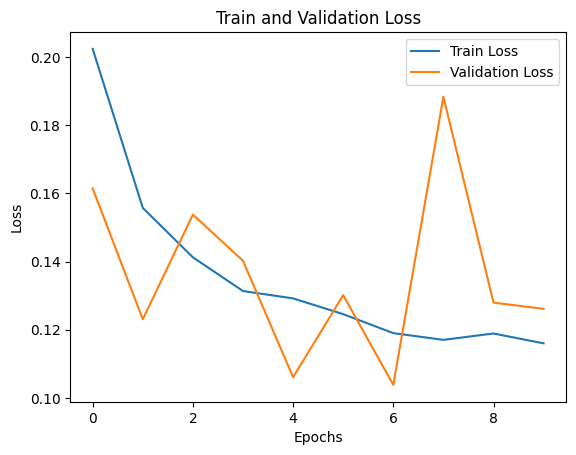

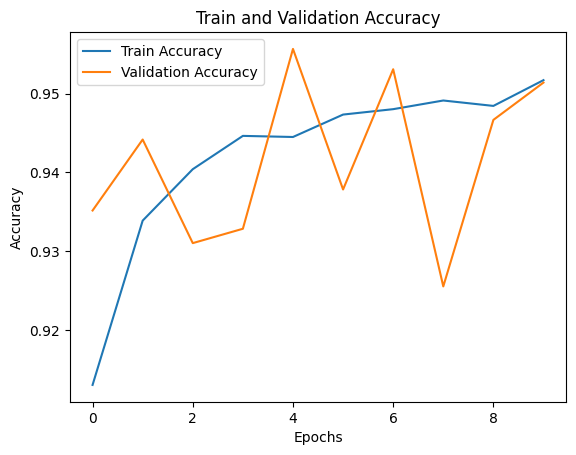

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

**Confusion Matrix**

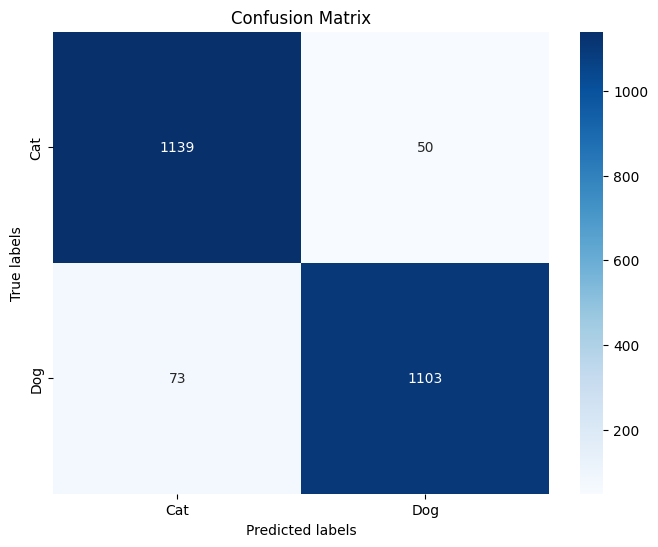

In [ ]:
# Define class names
class_names = ['Cat', 'Dog']

# Initialize empty lists to collect true and predicted labels
y_true_all = []
y_pred_all = []

# Iterate over the validation set to collect true and predicted labels
for batch in valid_loader:
    # A batch consists of image data and corresponding labels
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # Compute predictions for the batch
    with torch.no_grad():
        logits = model(imgs)
    preds = logits.argmax(dim=-1)

    # Append true and predicted labels to the lists
    y_true_all.extend(labels.cpu().numpy())
    y_pred_all.extend(preds.cpu().numpy())

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# Plot the confusion matrix with class names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

**Testing**

In [ ]:
# load best model weights
model.load_state_dict(torch.load('best_model.pth'))

model.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      logits = model(imgs)

    loss = criterion(logits, labels)
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/121 [00:00<?, ?it/s]

Test accuracy 0.9403969645500183


## **MODELING (RESNET 18)**

In [ ]:
class MyResNet18(nn.Module):
    def __init__(self):
        super(MyResNet18, self).__init__()

        # Load the pre-trained ResNet-18 model
        resnet18 = models.resnet18(pretrained=True)

        self.features = nn.Sequential(*list(resnet18.children())[:-1])

        # Define your custom fully connected layer for classification
        self.fc_layers = nn.Sequential(
            nn.Linear(512, 256),  # ResNet-18 outputs features
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(128, 2)  # Output layer with 2 classes
        )

    def forward(self, x):

        # Extract features using ResNet-18
        x = self.features(x)

        # Flatten the feature map
        x = x.view(x.size(0), -1)

        # Pass through fully connected layers
        x = self.fc_layers(x)

        return x

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = MyResNet18()
model = model.to(device)

In [ ]:
# showing summary of MyResNet18 model
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

**Define Loss and Optimizer**

In [ ]:
# Define Loss
criterion = nn.CrossEntropyLoss()

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

**Train and Validation**

In [ ]:
# The number of training epochs.
n_epochs = 10

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        optimizer.zero_grad()

        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        acc = (logits.argmax(dim=-1) == labels).float().mean()

        train_loss.append(loss.item())
        train_accs.append(acc.item())

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # Validation
    model.eval()
    valid_loss = []
    valid_accs = []

    with torch.no_grad():
        for batch in tqdm(valid_loader):
            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)

            loss = criterion(logits, labels)

            acc = (logits.argmax(dim=-1) == labels).float().mean()

            valid_loss.append(loss.item())
            valid_accs.append(acc.item())

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # Save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 001/010] Train: loss=0.18752, acc=0.92314 | Valid: loss=0.10874, acc=0.95097


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 002/010] Train: loss=0.14233, acc=0.94082 | Valid: loss=0.11671, acc=0.95097


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 003/010] Train: loss=0.12797, acc=0.94562 | Valid: loss=0.10121, acc=0.95562


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 004/010] Train: loss=0.11678, acc=0.95101 | Valid: loss=0.10195, acc=0.95599


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 005/010] Train: loss=0.11174, acc=0.95477 | Valid: loss=0.10895, acc=0.95477


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 006/010] Train: loss=0.10461, acc=0.95636 | Valid: loss=0.10075, acc=0.95684


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 007/010] Train: loss=0.10169, acc=0.95707 | Valid: loss=0.08365, acc=0.96195


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 008/010] Train: loss=0.10538, acc=0.95705 | Valid: loss=0.11110, acc=0.95468


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 009/010] Train: loss=0.10355, acc=0.95820 | Valid: loss=0.11465, acc=0.95228


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 010/010] Train: loss=0.09843, acc=0.96120 | Valid: loss=0.12299, acc=0.94844


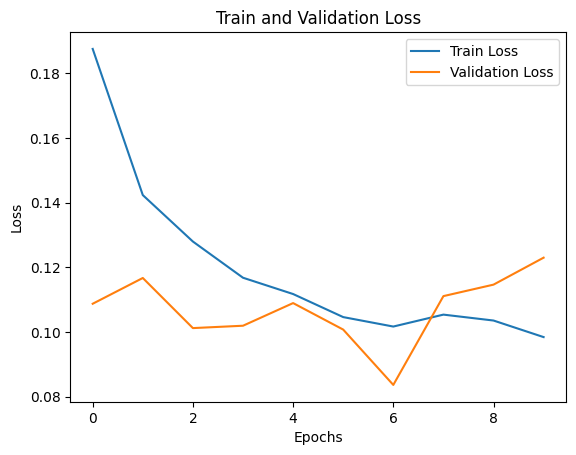

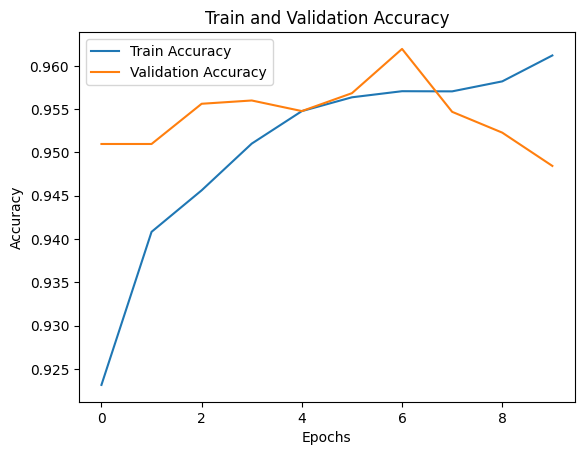

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

**Confusion Matrix**

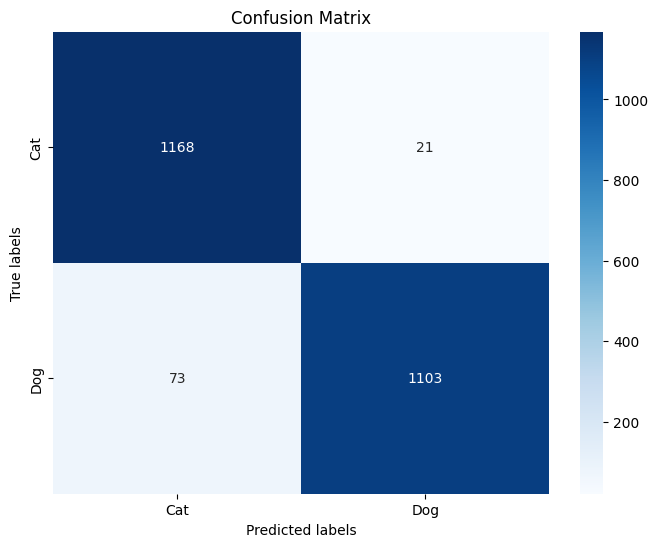

In [ ]:
# Define class names
class_names = ['Cat', 'Dog']

# Initialize empty lists to collect true and predicted labels
y_true_all = []
y_pred_all = []

# Iterate over the validation set to collect true and predicted labels
for batch in valid_loader:
    # A batch consists of image data and corresponding labels
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # Compute predictions for the batch
    with torch.no_grad():
        logits = model(imgs)
    preds = logits.argmax(dim=-1)

    # Append true and predicted labels to the lists
    y_true_all.extend(labels.cpu().numpy())
    y_pred_all.extend(preds.cpu().numpy())

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# Plot the confusion matrix with class names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

**Testing**

In [ ]:
# load best model weights
model.load_state_dict(torch.load('best_model.pth'))

model.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      logits = model(imgs)

    loss = criterion(logits, labels)
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/121 [00:00<?, ?it/s]

Test accuracy 0.9112130999565125


**MODELING (EFFICIENTNET B1)**

In [ ]:
!pip install timm
import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
class MyEfficientNetB1(nn.Module):
    def __init__(self):
        super(MyEfficientNetB1, self).__init__()

        # Load the pre-trained EfficientNet-B1 model
        efficientnet_b1 = timm.create_model('efficientnet_b1', pretrained=True)

        self.features = efficientnet_b1

        # Define custom fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(1000, 512),  # Output size from EfficientNet-B1's classifier
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 2)  # Output layer with 2 classes
        )

    def forward(self, x):
        # Extract features using EfficientNet-B1
        x = self.features(x)

        # Pass through fully connected layers
        x = self.fc_layers(x)

        return x

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = MyEfficientNetB1()
model = model.to(device)

In [ ]:
# showing summary of MyEfficientNetB1 model
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
          Identity-2         [-1, 32, 112, 112]               0
              SiLU-3         [-1, 32, 112, 112]               0
    BatchNormAct2d-4         [-1, 32, 112, 112]              64
            Conv2d-5         [-1, 32, 112, 112]             288
          Identity-6         [-1, 32, 112, 112]               0
              SiLU-7         [-1, 32, 112, 112]               0
    BatchNormAct2d-8         [-1, 32, 112, 112]              64
            Conv2d-9              [-1, 8, 1, 1]             264
             SiLU-10              [-1, 8, 1, 1]               0
           Conv2d-11             [-1, 32, 1, 1]             288
          Sigmoid-12             [-1, 32, 1, 1]               0
    SqueezeExcite-13         [-1, 32, 112, 112]               0
           Conv2d-14         [-1, 16, 1

**Define Loss and Optimizer**

In [ ]:
# Define Loss
criterion = nn.CrossEntropyLoss()

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

**Train and Validation**

In [ ]:
# The number of training epochs.
n_epochs = 10

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data.
        logits = model(imgs)

        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------

    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 001/010] Train: loss=0.13996, acc=0.94088 | Valid: loss=0.07027, acc=0.97251


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 002/010] Train: loss=0.08026, acc=0.96664 | Valid: loss=0.05421, acc=0.97800


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 003/010] Train: loss=0.06449, acc=0.97358 | Valid: loss=0.06001, acc=0.97504


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 004/010] Train: loss=0.06437, acc=0.97431 | Valid: loss=0.06295, acc=0.97255


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 005/010] Train: loss=0.05732, acc=0.97734 | Valid: loss=0.05619, acc=0.97715


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 006/010] Train: loss=0.05444, acc=0.97757 | Valid: loss=0.05286, acc=0.97677


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 007/010] Train: loss=0.05206, acc=0.97912 | Valid: loss=0.04393, acc=0.98269


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 008/010] Train: loss=0.04996, acc=0.98015 | Valid: loss=0.03924, acc=0.98100


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 009/010] Train: loss=0.04625, acc=0.98090 | Valid: loss=0.05163, acc=0.97884


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[Epoch: 010/010] Train: loss=0.05194, acc=0.98103 | Valid: loss=0.05168, acc=0.97762


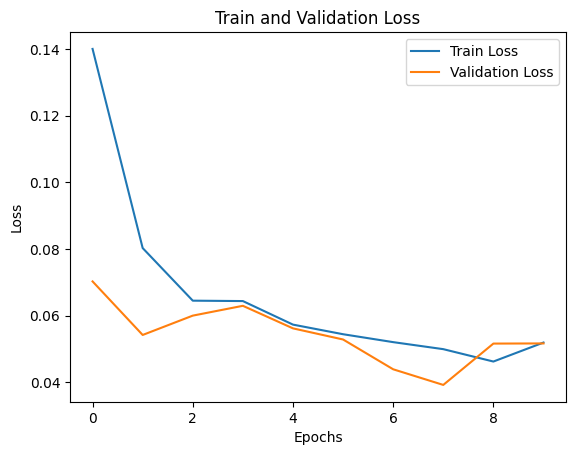

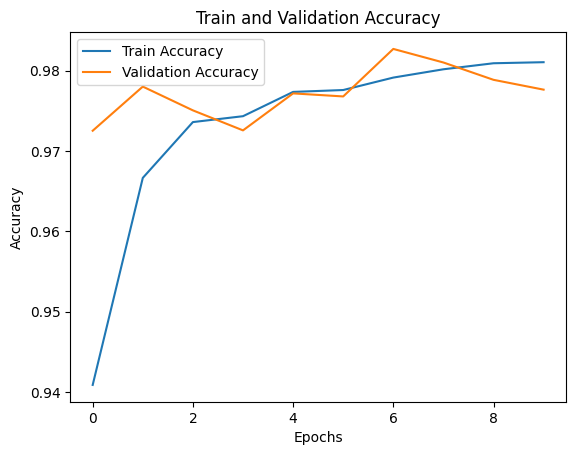

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

**Confusion Matrix**

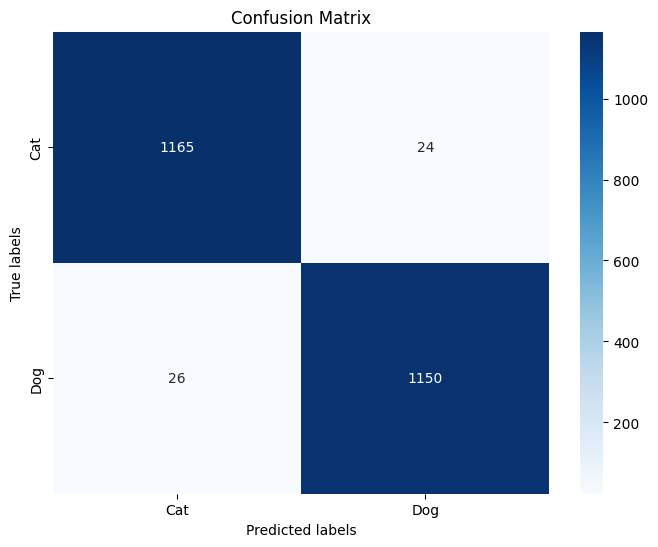

In [ ]:
# Define class names
class_names = ['Cat', 'Dog']

# Initialize empty lists to collect true and predicted labels
y_true_all = []
y_pred_all = []

# Iterate over the validation set to collect true and predicted labels
for batch in valid_loader:
    # A batch consists of image data and corresponding labels
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # Compute predictions for the batch
    with torch.no_grad():
        logits = model(imgs)
    preds = logits.argmax(dim=-1)

    # Append true and predicted labels to the lists
    y_true_all.extend(labels.cpu().numpy())
    y_pred_all.extend(preds.cpu().numpy())

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# Plot the confusion matrix with class names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

**Testing**

In [ ]:
# load best model weights
model.load_state_dict(torch.load('best_model.pth'))

model.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      logits = model(imgs)

    loss = criterion(logits, labels)
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/121 [00:00<?, ?it/s]

Test accuracy 0.985020637512207


## **Comparison of Model Accuracies**

In [ ]:
# Test accuracies
accuracies = [0.9112130999565125, 0.9403969645500183, 0.985020637512207]

# Models
models = ['RESNET18', 'VGG16', 'EFFICIENTNETB1']

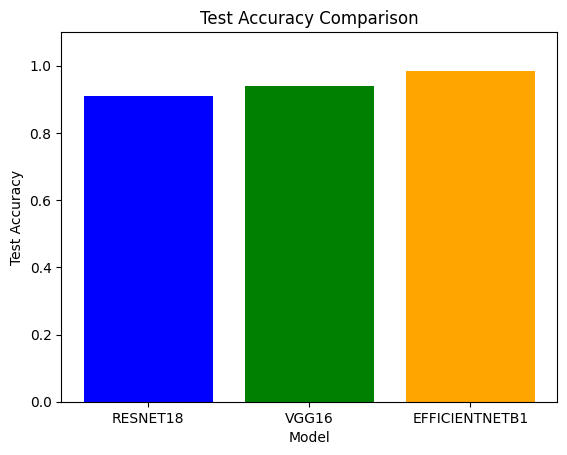

In [ ]:
# Create bar graph
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison')
plt.ylim(0, 1.1)
plt.show()

# This is to show that Efficientnet_B1 has the highest accuracy among all the trained models